# Capstone Project - Analysis of 2019 Chicago Homicides
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, I will analyze all the murders happened in Chicago in 2019.

Given the reputation Chicago has as a dangerous city, residents and tourists alike may wonder where and when most of the murders take place. I analyzed the trend of murders by location – distribution of the homicides by neighborhood – and by time - month, day, and part of the day. I also threw in the analysis a question not many may wonder: what are the most common venues around homicides?

## Data <a name="data"></a>

Based on the definition of the problem, the main factors playing a role in the study are:
* number and geolocation of **homicides**;
* top 5 venues near homicides;
* distribution of murders by neighborhood;
* distribution of murders by day, month, and time of the day.

The following will be used as data sources to extract/generate the required information:
* "Crimes - 2019" data available from the Chicago Data Portal at https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie
* venues geolocation obtained using **Foursquare API**

### Data Set Up

Import and install all needed libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import geocoder # import geocoder

print('Libraries imported.')

Libraries imported.


Import and clean up data from Chicago Data Portal.

In [2]:
#import the csv files extracted from the Chicago Data Portal that contain all homicide and burglary data
df = pd.read_csv('Crimes_Burglaries&Homicides-_2019.csv')
df.head()

,ID,Case Number,Date,Block,Time,Day,Month,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Neighborhood,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11579750,JC132874,1/24/2019 6:30,015XX W FARGO AVE,MORNING,Thu,Jan,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,2422,24,49,Rogers Park,1,5,NaN,NaN,2019,2/16/2019 15:59,NaN,NaN,NaN
1,11698842,JC277102,5/24/2019 16:15,122XX S WALLACE ST,AFTERNOON,Fri,May,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,523,5,34,West Pullman,53,5,1174522.0,1823699.0,2019,6/30/2019 15:56,41.671619,-87.636893,"(41.671619054, -87.636893184)"
2,11712228,JC293479,6/5/2019 15:00,083XX S ELLIS AVE,AFTERNOON,Wed,Jun,630,BURGLARY,ATTEMPT FORCIBLE ENTRY,RESIDENCE,False,False,632,6,8,Chatham,44,5,1184340.0,1849824.0,2019,6/30/2019 15:56,41.743086,-87.600146,"(41.743085927, -87.600145655)"
3,11712512,JC293551,6/5/2019 8:40,011XX S MICHIGAN AVE,MORNING,Wed,Jun,610,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,False,123,1,4,Loop,32,5,1177422.0,1895476.0,2019,6/30/2019 15:56,41.868518,-87.624113,"(41.868518128, -87.624113021)"
4,11713772,JC295505,6/6/2019 23:00,034XX W FULTON BLVD,NIGHT,Thu,Jun,650,BURGLARY,HOME INVASION,APARTMENT,False,False,1123,11,28,East Garfield Park,27,5,1153457.0,1901786.0,2019,6/30/2019 15:56,41.886343,-87.711926,"(41.886343054, -87.711926124)"


In [3]:
#drop a few columns to have a dataframe only necessary data
df = df.drop(columns=['IUCR','Arrest','Domestic','Beat','District','Ward','FBI Code','Year','Updated On'], axis= 1)
df.head()

,ID,Case Number,Date,Block,Time,Day,Month,Primary Type,Description,Location Description,Neighborhood,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude,Location
0,11579750,JC132874,1/24/2019 6:30,015XX W FARGO AVE,MORNING,Thu,Jan,BURGLARY,FORCIBLE ENTRY,RESIDENCE,Rogers Park,1,NaN,NaN,NaN,NaN,NaN
1,11698842,JC277102,5/24/2019 16:15,122XX S WALLACE ST,AFTERNOON,Fri,May,BURGLARY,FORCIBLE ENTRY,RESIDENCE,West Pullman,53,1174522.0,1823699.0,41.671619,-87.636893,"(41.671619054, -87.636893184)"
2,11712228,JC293479,6/5/2019 15:00,083XX S ELLIS AVE,AFTERNOON,Wed,Jun,BURGLARY,ATTEMPT FORCIBLE ENTRY,RESIDENCE,Chatham,44,1184340.0,1849824.0,41.743086,-87.600146,"(41.743085927, -87.600145655)"
3,11712512,JC293551,6/5/2019 8:40,011XX S MICHIGAN AVE,MORNING,Wed,Jun,BURGLARY,FORCIBLE ENTRY,APARTMENT,Loop,32,1177422.0,1895476.0,41.868518,-87.624113,"(41.868518128, -87.624113021)"
4,11713772,JC295505,6/6/2019 23:00,034XX W FULTON BLVD,NIGHT,Thu,Jun,BURGLARY,HOME INVASION,APARTMENT,East Garfield Park,27,1153457.0,1901786.0,41.886343,-87.711926,"(41.886343054, -87.711926124)"


In [4]:
#rename column 'Primary Type' for later functions
df = df.rename(columns={"Primary Type":"Primary_Type","X Coordinate": "X", "Y Coordinate":"Y","Community_Name":"Neighborhood"})
df.head()

,ID,Case Number,Date,Block,Time,Day,Month,Primary_Type,Description,Location Description,Neighborhood,Community Area,X,Y,Latitude,Longitude,Location
0,11579750,JC132874,1/24/2019 6:30,015XX W FARGO AVE,MORNING,Thu,Jan,BURGLARY,FORCIBLE ENTRY,RESIDENCE,Rogers Park,1,NaN,NaN,NaN,NaN,NaN
1,11698842,JC277102,5/24/2019 16:15,122XX S WALLACE ST,AFTERNOON,Fri,May,BURGLARY,FORCIBLE ENTRY,RESIDENCE,West Pullman,53,1174522.0,1823699.0,41.671619,-87.636893,"(41.671619054, -87.636893184)"
2,11712228,JC293479,6/5/2019 15:00,083XX S ELLIS AVE,AFTERNOON,Wed,Jun,BURGLARY,ATTEMPT FORCIBLE ENTRY,RESIDENCE,Chatham,44,1184340.0,1849824.0,41.743086,-87.600146,"(41.743085927, -87.600145655)"
3,11712512,JC293551,6/5/2019 8:40,011XX S MICHIGAN AVE,MORNING,Wed,Jun,BURGLARY,FORCIBLE ENTRY,APARTMENT,Loop,32,1177422.0,1895476.0,41.868518,-87.624113,"(41.868518128, -87.624113021)"
4,11713772,JC295505,6/6/2019 23:00,034XX W FULTON BLVD,NIGHT,Thu,Jun,BURGLARY,HOME INVASION,APARTMENT,East Garfield Park,27,1153457.0,1901786.0,41.886343,-87.711926,"(41.886343054, -87.711926124)"


Drop NaN rows.

In [5]:
df.shape

(6703, 17)

In [6]:
df = df.dropna(subset=['Location'])
df.shape

(6701, 17)

Slice the dataframe to create a dataframe that contains only homicides.

In [7]:
df_homicides = df[df.Primary_Type == 'HOMICIDE']
df_homicides.head()

,ID,Case Number,Date,Block,Time,Day,Month,Primary_Type,Description,Location Description,Neighborhood,Community Area,X,Y,Latitude,Longitude,Location
6199,24561,JC281195,5/27/2019 23:42,085XX S CICERO AVE,NIGHT,Mon,May,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,Ashburn,70,1145925.0,1847569.0,41.737710,-87.740958,"(41.737709752, -87.740958098)"
6200,24562,JC281250,5/28/2019 0:25,018XX N MONTICELLO AVE,NIGHT,Tue,May,HOMICIDE,FIRST DEGREE MURDER,PARK PROPERTY,Logan Square,22,1151758.0,1911886.0,41.914092,-87.717899,"(41.914092032, -87.717899225)"
6201,24563,JC281514,5/28/2019 9:25,012XX N MASON AVE,MORNING,Tue,May,HOMICIDE,FIRST DEGREE MURDER,STREET,Austin,25,1136467.0,1907694.0,41.902876,-87.774177,"(41.902876025, -87.774176927)"
6202,24567,JC283353,5/29/2019 14:24,087XX S KINGSTON AVE,AFTERNOON,Wed,May,HOMICIDE,FIRST DEGREE MURDER,STREET,South Chicago,46,1194656.0,1847614.0,41.736774,-87.562421,"(41.736774091, -87.562420599)"
6203,24566,JC283120,5/29/2019 11:42,018XX W 57TH ST,MORNING,Wed,May,HOMICIDE,FIRST DEGREE MURDER,STREET,West Englewood,67,1164886.0,1866877.0,41.790314,-87.670945,"(41.790314426, -87.670944722)"


In [8]:
# get the first 100 crimes in the df dataframe
limit = 100
df_100 = df_homicides.iloc[0:limit, :]
df_100.shape

(100, 17)

## Methodology

Let's analyze the dataframe focusing on two kinds of information:
1. Location data;
2. Time data.

### Explore Crimes with Folium Maps

In [9]:
# Chicago latitude and longitude values
latitude = 41.8781
longitude = -87.6298

In [10]:
# create map and display it
chi_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# display the map of Chicago
chi_map

Now let's superimpose the locations of the crimes onto the map. The way to do that in **Folium** is to create a *feature group* with its own features and style and then add it to the chi_map.

In [11]:
from folium import plugins

# let's start again with a clean copy of the map of Chicago
chi_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the homicides in the dataframe
homicides = plugins.MarkerCluster().add_to(chi_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_homicides.Latitude, df_homicides.Longitude, df_homicides.Neighborhood):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(homicides)

# display map
chi_map

In [12]:
#let's see a list of the neighborhoods and relative homicides.
df_homicides['Neighborhood'].value_counts()

Austin                    54
Humboldt Park             28
Roseland                  28
Greater Grand Crossing    26
West Garfield Park        24
North Lawndale            24
South Shore               22
West Englewood            20
Auburn Gresham            20
Englewood                 20
East Garfield Park        17
Chicago Lawn              17
South Chicago             16
South Lawndale            14
Chatham                   12
Washington Park           11
Near West Side             8
Woodlawn                   8
New City                   7
Lower West Side            6
Rogers Park                6
Washington Heights         6
Dunning                    6
East Side                  6
West Pullman               6
Gage Park                  6
Belmont Cragin             5
Grand Boulevard            5
Ashburn                    5
West Town                  5
Logan Square               4
Fuller Park                4
Morgan Park                4
Pullman                    4
Garfield Ridge

Let's see the distribution of homicides per neighborhood on a whisker plot.

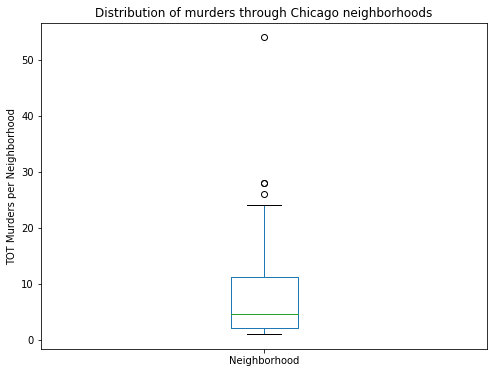

In [13]:
df_homplot = df_homicides['Neighborhood'].value_counts().to_frame()

df_homplot.plot(kind='box', figsize=(8, 6))

plt.title('Distribution of murders through Chicago neighborhoods')
plt.ylabel('TOT Murders per Neighborhood')

plt.show()

## What are the top 3 venues around the homicide location?
*Let's find it out by retrieving venues from the Foursquare database.*

Set up Foursquare API.

In [14]:
LIMIT = 10

CLIENT_ID = 'R1DBAIMUSTYTILYYU5JPIT5XCOVFKQY52OFOF5I0XNN3THQB' # your Foursquare ID
CLIENT_SECRET = 'JXFDWJYHDVGTJ1DPIJPAU3RV1AVAER3P1QKMIRUFUZJH2RPC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R1DBAIMUSTYTILYYU5JPIT5XCOVFKQY52OFOF5I0XNN3THQB
CLIENT_SECRET:JXFDWJYHDVGTJ1DPIJPAU3RV1AVAER3P1QKMIRUFUZJH2RPC


#### Let's create a function to extract the closest venues in a 200m radius from all of the homicides location.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Case Number', 
                  'Case Number Latitude', 
                  'Case Number Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now I'll run run the above function on each homicide location and create a new dataframe called *hom_venues*.

In [16]:
hom_venues = getNearbyVenues(names=df_homicides['Case Number'],
                                   latitudes=df_homicides['Latitude'],
                                   longitudes=df_homicides['Longitude']
                                  )

JC281195
JC281250
JC281514
JC283353
JC283120
JC282752
JC282729
JC284016
JC228896
JC284673
JC284673
JC280830
JC286989
JC286896
JC286876
JC287285
JC287360
JC287087
JC288642
JC288606
JC288642
JC290416
JC162598
JC287306
JC292411
JC293193
JC250415
JC293720
JC292611
JC294466
JC295496
JC297067
JC297685
JB501110
JC298437
JC302499
JC137846
JC302619
JC299535
JC178163
JC305090
JC304063
JC271728
JC306523
JC308069
JC307166
JC308418
JC308347
JC309467
JC309361
JC309564
JC311051
JC313130
JC313110
JC314445
JC228553
JC315607
JC316334
JC315071
JC315715
JC316403
JC316580
JC381991
JC383001
JC386283
JC387139
JC386278
JC386294
JC387318
JC389022
JC317994
JC317433
JC323132
JC324333
JC326322
HR439906
JC326856
JC327983
JC327352
JC326640
JC330856
JC331056
JC331388
JC333404
JC334372
JC335335
JC336427
JC335320
JC337772
JC338230
JC106397
JC340296
JC167528
JC279072
JC346016
JC345103
JC344149
JC347217
JC346830
JC346570
JC347770
JC347770
JC346537
JC346582
JC347994
JC348081
JC348471
JC350685
JC240092
JC354738
JC353545
J

Groupby the above results by Venue Category.

In [17]:
hom_venuecount = hom_venues.groupby('Venue Category').size()
hom_venuecount.head()

Venue Category
ATM                     6
Accessories Store       1
African Restaurant      4
American Restaurant    35
Arcade                  1
dtype: int64

In [35]:
#insert hom_venuecount in a pandas dataframe and sort the values in descending order
df_venue = pd.DataFrame(hom_venuecount, columns=['Count']).sort_values(by=['Count'], ascending=False)
df_venue.head(20)

,Count
Venue Category,
Fast Food Restaurant,67
Mexican Restaurant,58
Sandwich Place,46
Pizza Place,46
Fried Chicken Joint,45
Grocery Store,39
Discount Store,36
American Restaurant,35
Bar,34


### Chart most common venues

In [36]:
#select top 5 closest venues
df_5 = df_venue.iloc[0:5, :].sort_values('Count')
df_5

,Count
Venue Category,
Fried Chicken Joint,45
Sandwich Place,46
Pizza Place,46
Mexican Restaurant,58
Fast Food Restaurant,67


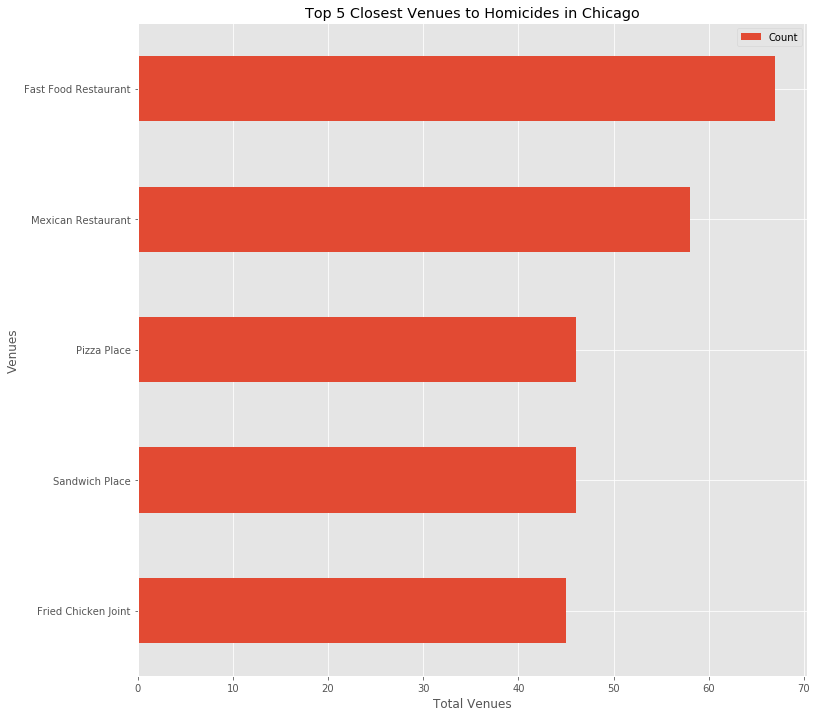

In [37]:
mpl.style.use('ggplot') # optional: for ggplot-like style

### type your answer here
#plot
df_5.plot(kind='barh',figsize=(12,12))
plt.title('Top 5 Closest Venues to Homicides in Chicago')
plt.xlabel('Total Venues')
plt.ylabel('Venues')

plt.show()


## When did homicides happen more frequently in Chicago in 2019?

Let's analyze homicides' most frequent days and times.

In [23]:
df_date = df_homicides[['Time','Month','Day']].reset_index().drop(['index'],axis=1)
df_date.head()

,Time,Month,Day
0,NIGHT,May,Mon
1,NIGHT,May,Tue
2,MORNING,May,Tue
3,AFTERNOON,May,Wed
4,MORNING,May,Wed


In [24]:
df_date.shape

(504, 3)

### Explore distribution of homicides throughout the day.

In [25]:
df_time = df_date['Time'].value_counts().to_frame()
df_time

,Time
NIGHT,198
AFTERNOON,125
EVENING,110
MORNING,71


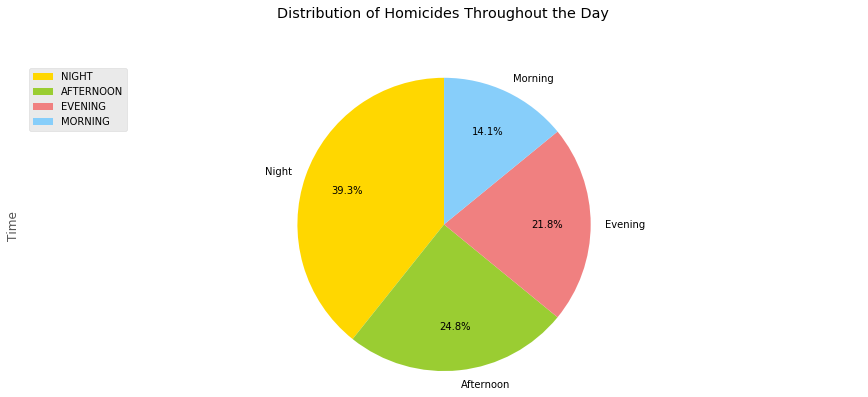

In [26]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
labels = 'Night','Afternoon','Evening','Morning'

df_time['Time'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                                   
                            labels=labels,         # turn off labels on pie chart
                            pctdistance=0.7,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            
                            )

# scale the title up by 12% to match pctdistance
plt.title('Distribution of Homicides Throughout the Day', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_time.index, loc='upper left') 

plt.show()

### Explore monthly distribution.

In [27]:
df_month = df_date['Month'].value_counts().to_frame().reset_index().rename(columns={"index":"Month","Month":"Count"})
df_month

,Month,Count
0,Apr,61
1,May,54
2,Jun,52
3,Aug,51
4,Sep,50
5,Jul,44
6,Oct,41
7,Mar,36
8,Nov,34
9,Dec,34


In [28]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df_month['Month'] = pd.Categorical(df_month['Month'], categories=months, ordered=True)
df_month.sort_index(axis=1, ascending=False)
df_mo = df_month.sort_values('Month')
df_mo.index= months
df_mo

,Month,Count
Jan,Jan,22
Feb,Feb,25
Mar,Mar,36
Apr,Apr,61
May,May,54
Jun,Jun,52
Jul,Jul,44
Aug,Aug,51
Sep,Sep,50
Oct,Oct,41


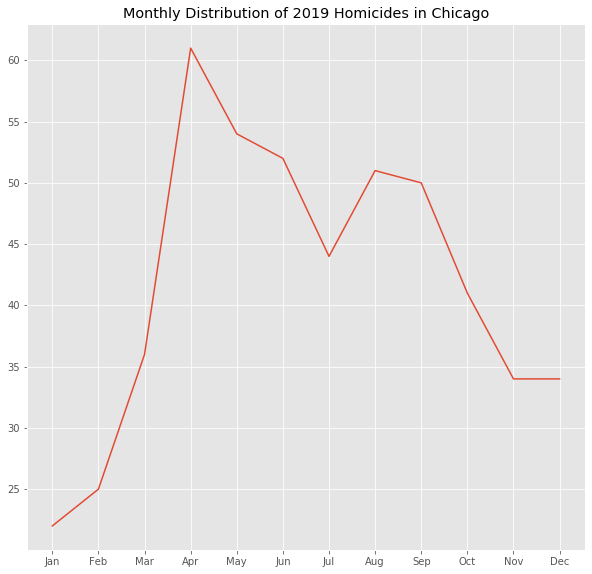

In [29]:
x = df_mo.index
y = df_mo['Count']
labels = months

plt.figure(figsize=(10,10))
plt.plot(x, y)
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels)
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.05)
plt.title('Monthly Distribution of 2019 Homicides in Chicago')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

### Explore daily distribution.

In [30]:
df_day = df_date['Day'].value_counts().to_frame().reset_index().rename(columns={"index":"Day","Day":"Count"})
df_day

,Day,Count
0,Sat,105
1,Sun,94
2,Fri,67
3,Tue,63
4,Wed,61
5,Thu,58
6,Mon,56


In [31]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", 
          "Sun"]
df_day['Day'] = pd.Categorical(df_day['Day'], categories=days, ordered=True)
df_day.sort_index(axis=1, ascending=False)
df_d = df_day.sort_values('Day')
df_d.index= days
df_d

,Day,Count
Mon,Mon,56
Tue,Tue,63
Wed,Wed,61
Thu,Thu,58
Fri,Fri,67
Sat,Sat,105
Sun,Sun,94


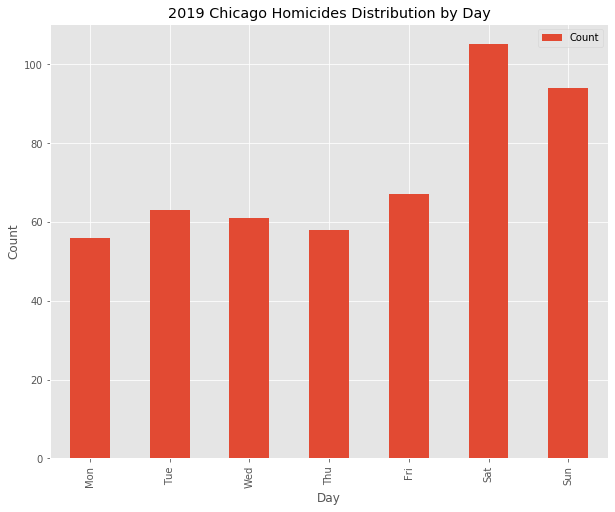

In [32]:
# step 2: plot data
df_d.plot(kind='bar', figsize=(10, 8))

plt.xlabel('Day') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('2019 Chicago Homicides Distribution by Day') # add title to the plot

plt.show()

<hr>

## Conclusion

In this study, I analyzed the 505 murders that happened in Chicago in 2019. My analysis focused on **location** and **time** data. It surprisingly found out that the neighborhood with the highest number of homicides was not in the southern area; indeed, **Austin** – a western neighborhood – topped the list with an astonishing 54 total crimes, marking itself as an *outlier*. Also, by extracting data from Foursquare, I located the most common venue categories in a 200m radius from each crime. As shown in figure 3, murders happened the most near fast foods, Mexican restaurants, and pizza places, leaving out train stations, parks, and bus stations away from the top 10. With regards to time data, my analysis found out that most of the homicides happened during **spring and summer** (leaving the winter season last), during **weekends** (almost 40% happened on a Saturday or Sunday), and mainly at **night** (40%.) I am sure residents of the Chicagoland will find this data interesting; my analysis wanted to shed some light on a topic that is surely widely discussed in Chicago, yet without the proper data.